## Load Base

In [2]:
from glob import glob
import os
from skimage.io import imread

def load_images(DATABASE_PATH, classes, qtd_imagens=1300):
    database = []
    
    for classe in classes:
        IMAGES_PATH = classe + '/images'

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, IMAGES_PATH, '*.png'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME[0:qtd_imagens]:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)

    return database

In [3]:
DATABASE_PATH = 'COVID-19_Radiography_Dataset/'

classes = ['Normal', 'COVID', 'Viral Pneumonia']

database = load_images(DATABASE_PATH, classes, qtd_imagens=1300)

In [4]:
len(database[0]), len(database[1]), len(database[2])

(1300, 1300, 1300)

## Preprocessing

In [5]:
from skimage.filters import laplace
from matplotlib import pyplot as plt
import numpy as np
import abc

In [6]:
class Imagem():
    def __init__(self, database):
        self._database = database

    def img(self, classe, indice):
        return self._database[classe][indice]
    
    @property
    def classes_lenght(self):
        return len(self._database)
    
    @property
    def indices_lenght(self):
        return len(self._database[0])

In [7]:
class ImagemDecorator(abc.ABC):
    def __init__(self, componente):
        self._componente = componente
    
    @abc.abstractmethod
    def img(self, classe, indice):
        pass

    @property
    def classes_lenght(self):
        return self._componente.classes_lenght
    
    @property
    def indices_lenght(self):
        return self._componente.indices_lenght

In [8]:
class ImagemPotencia(ImagemDecorator):

    def img(self, classe, indice):
        image_array = np.array(self._componente.img(classe, indice), dtype='float')
        
        return 1 * np.power(image_array, 0.5) 

In [9]:
class ImagemLaplace(ImagemDecorator):
   
    def img(self, classe, indice):
        img = self._componente.img(classe, indice)

        img_laplace = laplace(img.astype(np.float64))

        img_detalhada = img + (1 * img_laplace)

        img_detalhada[img_detalhada < 0] = 0
        img_detalhada[img_detalhada > 255] = 255

        return img_detalhada

In [10]:
imagem = Imagem(database)

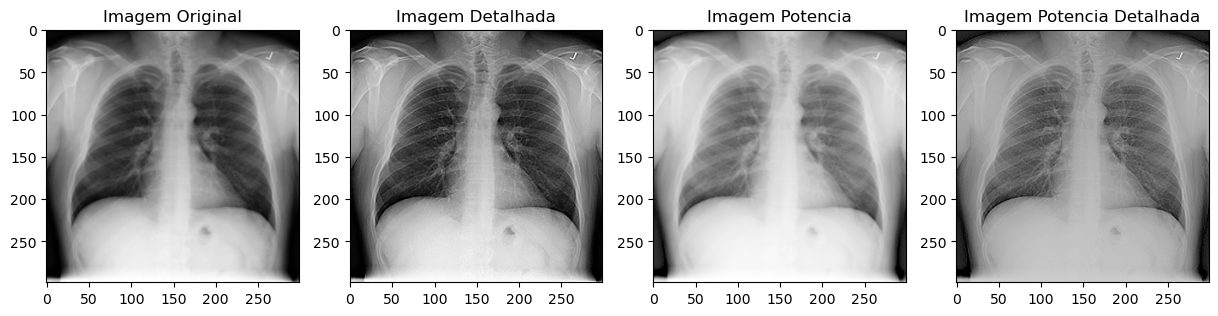

In [11]:
classe, indice = 0, 1

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 4, 1)
plt.imshow(imagem.img(classe, indice), cmap='gray')
plt.title('Imagem Original')
fig.add_subplot(1, 4, 2)
plt.imshow(ImagemLaplace(imagem).img(classe, indice), cmap='gray')
plt.title('Imagem Detalhada')
fig.add_subplot(1, 4, 3)
plt.imshow(ImagemPotencia(imagem).img(classe, indice), cmap='gray')
plt.title('Imagem Potencia')
fig.add_subplot(1, 4, 4)
plt.imshow(ImagemLaplace(ImagemPotencia(imagem)).img(classe, indice), cmap='gray')
plt.title('Imagem Potencia Detalhada');


## Descriptors

In [12]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from skimage.color import gray2rgb
import cv2


def energy(x):
    return np.sum(np.power(x, 2))

In [13]:
classe, indice = 0, 1

In [14]:
class Descritores():
    def __init__(self, componente):
        self._componente = componente

    def first(self, classe, indice):
        frequencias, _ = np.histogram(self._componente.img(classe, indice), bins=256, density=True)

        media = np.mean(frequencias)

        var = np.var(frequencias)

        sk = skew(frequencias)

        kur = kurtosis(frequencias)

        ener = energy(frequencias)

        entr = entropy(frequencias)

        return [media,var,sk,kur,ener,entr]

    def second(self, classe, indice):
        glcm = graycomatrix(self._componente.img(classe, indice).astype(np.int64), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

        contrast = graycoprops(glcm, 'contrast')

        dissimilarity = graycoprops(glcm, 'dissimilarity')

        homogeneity = graycoprops(glcm, 'homogeneity')

        ASM = graycoprops(glcm, 'ASM')

        energy = graycoprops(glcm, 'energy')
        
        correlation = graycoprops(glcm, 'correlation')
        
        return [contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0]]

    def third(self, classe, indice):
        model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        img = gray2rgb(self._componente.img(classe, indice))
        img = cv2.resize(img, (224, 224))        
        # expandindo as dimensões do array para que ele possa ser processado pelo modelo
        img = np.expand_dims(img, axis=0)

        # pré-processando a imagem
        img = preprocess_input(img)
        # obtendo as características da imagem
        features = model.predict(img)

        # exibindo as dimensões das características
        return features.flatten()

    def x_y_split(self, tipo='first'):
        x = []
        y = []

        if tipo.lower() == 'second':
            descritor_function = self.second
        elif tipo.lower() == 'third':
            descritor_function = self.third
        else:
            descritor_function = self.first

        classes = self._componente.classes_lenght
        indices = self._componente.indices_lenght

        for classe in range(classes):
            for indice in range(indices):
                x.append(descritor_function(classe, indice))
                y.append(classe)

        return x, y

In [15]:
descritores = Descritores(imagem)

In [16]:
print(descritores.first(classe, indice))
print(descritores.second(classe, indice))
print(descritores.third(classe, indice).shape)

[0.004, 2.4234120969893305e-06, -0.498311747524521, -0.035521594677382584, 0.004716393496829268, 5.45267093969021]
[22.540021548337865, 2.977520145451281, 0.367745531099122, 0.0005114555853060566, 0.022615383819560894, 0.9973493911103907]
1/1 [==============================] - 4s 4s/step
(50176,)


## Classification

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [18]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score
#metrics = ['accuracy', 'f1_weighted']
scoring = {'kappa': make_scorer(cohen_kappa_score),
           'acc': 'accuracy',
           'f1': 'f1_weighted'}

In [19]:
def string_metricas(scores, cross_kappa=None):
    print(scores)
    metricas_string = 'Acuracia: {} (+/- {})'.format(scores['test_acc'].mean(), scores['test_acc'].std())
    metricas_string += '\nF1: {} (+/- {})'.format(scores['test_f1'].mean(), scores['test_f1'].std())
    metricas_string += '\nKappa: {} (+/- {})'.format(scores['test_kappa'].mean(), scores['test_kappa'].std())
    #metricas_string += '\nKappa: {} (+/- {})'.format(cross_kappa['test_score'].mean(), cross_kappa['test_score'].std())
    metricas_string += '\n\n'

    return metricas_string

In [20]:
rf = RandomForestClassifier()
svm = SVC()
lgbm = LGBMClassifier()

In [21]:
resultados = open('resultados.txt', 'a')
# resultados.write('Resultados sem segmentação\n\n')

In [22]:
imagem = Imagem(database)

imagem_potencia_laplace = ImagemLaplace(ImagemPotencia(imagem))

descritores_normal = Descritores(imagem)
descritores_potencia_laplace = Descritores(imagem_potencia_laplace)

In [23]:
descritores = descritores_normal
classificador = lgbm
tipo = 'third'

# for tipo in ('first', 'second', 'third'):
x, y = descritores.x_y_split(tipo)

resultados.write(f'Original third LightGBM\n\n')
    
cross = cross_validate(classificador, x, y, cv=5, scoring=scoring, n_jobs=-1)

resultados.write(string_metricas(cross))

1/1 [==============================] - 1s 565ms/step
{'fit_time': array([2638.83614779, 2701.70117736, 3179.56717253, 3188.17153168,
       2105.77914286]), 'score_time': array([1.87904048, 1.49399924, 1.4429996 , 1.42002892, 1.90099645]), 'test_kappa': array([0.93846154, 0.92115385, 0.89230769, 0.91153846, 0.91346154]), 'test_acc': array([0.95897436, 0.9474359 , 0.92820513, 0.94102564, 0.94230769]), 'test_f1': array([0.95910446, 0.94750003, 0.92802451, 0.94120367, 0.94234786])}


160

In [ ]:
for nome_preprocessamento, descritores in {'Original': descritores_normal, 'Potencia Laplace': descritores_potencia_laplace}.items():
    for tipo in ('first', 'second', 'third'):
        x, y = descritores.x_y_split(tipo)
        for nome_classificador, classificador in {'Random Forest': rf, 'SVM': svm, 'LightGBM': lgbm}.items():
            resultados.write(f'{nome_preprocessamento} {tipo} {nome_classificador}\n\n')
            cross = cross_validate(classificador, x, y, cv=5, scoring=scoring, n_jobs=-1)
            # kappa = make_scorer(cohen_kappa_score)
            # cross_kappa = cross_validate(classificador, x, y, cv=5, scoring=kappa, n_jobs=-1)
            resultados.write(string_metricas(cross))

In [24]:
resultados.close()